<a href="https://colab.research.google.com/github/cyFou/testColab/blob/main/ia2thor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source du tuto
https://levelup.gitconnected.com/building-a-perfect-million-parameter-llm-like-chatgpt-in-python-3b16e26b4139


# Creation du fichier jeu de données

In [ ]:
# faire un ctrl C en fonction de la taille souhaité du jdd
!wget https://www.modelscope.cn/datasets/deepctrl/deepctrl-sft-data/resolve/master/sft_data_fr.jsonl

# import os,urllib
# url = 'https://www.modelscope.cn/datasets/deepctrl/deepctrl-sft-data/resolve/master/sft_data_en.jsonl'
# filename = './sft_data_en.jsonl'
# if not os.path.isfile(filename):
#     urllib.request.urlretrieve(url, filename)


--2025-03-30 14:56:33--  https://www.modelscope.cn/datasets/deepctrl/deepctrl-sft-data/resolve/master/sft_data_fr.jsonl
Resolving www.modelscope.cn (www.modelscope.cn)... 47.92.141.220, 39.99.133.195
Connecting to www.modelscope.cn (www.modelscope.cn)|47.92.141.220|:443... connected.
HTTP request sent, awaiting response... 404 
2025-03-30 14:56:34 ERROR 404: (no description).



In [ ]:
# Supprimer la dernière ligne du fichier sft_data_en.jsonl car mal formaté du fait du Ctrl C
def remove_last_line(filepath):
    """Removes the last line of a large file efficiently.

    Args:
      filepath: The path to the file.
    """
    try:
        with open(filepath, 'rb+') as f:
            f.seek(-2, os.SEEK_END)  # Go to the second-to-last byte
            while f.read(1) != b'\n':
                f.seek(-2, os.SEEK_CUR)  # Back up two bytes
                if f.tell() == 0:
                    # Handle the case where there's only one line or no newline chars.
                    f.truncate(0)
                    return
            f.truncate()
    except OSError as e:
        print(f"Error removing last line from {filepath}: {e}")
        return

remove_last_line("sft_data_en.jsonl")

In [ ]:
# Supprimer la dernière ligne du fichier sft_data_en.jsonl car mal formaté du fait du Ctrl C
!sed -i '$d' sft_data_en.jsonl


In [ ]:
# import json
# from tqdm import tqdm

# file_path = "sft_data_en.jsonl" # Downloaded filepath (23 GB RAM REQUIRED!!!!!!!!!!!!!!!!!!!!!)

# # Read the JSONL file with tqdm progress bar
# data = []
# with open(file_path, "r", encoding="utf-8") as file:
#     # Iterate through each line of the JSONL file
#     for line in tqdm(file, desc="Loading JSONL file"):
#         # Parse each line as a JSON object and append to data
#         data.append(json.loads(line))

# print(len(data))

In [ ]:

##### retravaille le fichier de données : ligne de 512 caratère, supression (en grande partie) des lignes avec caratère asiatique

import json
from tqdm import tqdm
import re

file_path = "sft_data_en.jsonl"

# Define the output file name
output_file = "petrain_data.jsonl"

lenAfterFilter = 0
# Write data to JSONL format
asian_char_pattern = re.compile(r'[\u4E00-\u9FFF\u3040-\u30FF\uAC00-\uD7AF]')
with open(file_path, 'r', encoding='utf-8') as infile, open(output_file, 'w', encoding='utf-8') as outfile:
    for line in tqdm(infile, desc="Filter JSONL file"):
        item = json.loads(line)
        io_length = len(item['input']) + len(item['output'])
        if io_length < 512 and not asian_char_pattern.search(line):
            json.dump({"text": f"{item['input']}\n{item['output']}"}, outfile, ensure_ascii=False)
            outfile.write("\n")  # Newline for each JSONL entry
            lenAfterFilter+=1
print(f"New JSONL file saved as {output_file}")
print(lenAfterFilter)

Filter JSONL file: 48459it [00:01, 26400.15it/s]

New JSONL file saved as petrain_data.jsonl
3122


# Creation du dataset

In [ ]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
import json
from tqdm import tqdm
import re



In [ ]:
class PretrainDataset(Dataset):
    """Dataset for pretraining."""

    def __init__(self, data_path, tokenizer, max_length=512):
        """
        Initializes the PretrainDataset.

        Args:
            data_path (str): Path to the JSONL data file.
            tokenizer: The tokenizer to use.
            max_length (int): Maximum sequence length.
        """
        super().__init__()
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.samples = self.load_data(data_path)

    def load_data(self, path):
        """
        Loads data from a JSONL file.

        Args:
            path (str): Path to the JSONL file.

        Returns:
            list: A list of samples loaded from the file.
        """
        samples = []
        with open(path, 'r', encoding='utf-8') as f:
            for line_num, line in enumerate(f, 1):  # enumerate starts at 1 for line_num
                data = json.loads(line.strip())
                samples.append(data)
        return samples

    def __len__(self):
        """Returns the number of samples in the dataset."""
        return len(self.samples)

    def __getitem__(self, index):
        """
        Retrieves a sample from the dataset.

        Args:
            index (int): Index of the sample to retrieve.

        Returns:
            tuple: A tuple containing the input (X), target (Y), and loss mask.
        """
        sample = self.samples[index]

        # Construct the input text, including BOS and EOS tokens.
        text = f"{self.tokenizer.bos_token}{str(sample['text'])}{self.tokenizer.eos_token}"
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',  # Pad to max_length
            truncation=True,  # Truncate to max_length
            return_tensors='pt'  # Return PyTorch tensors
        )
        input_ids = encoding.input_ids.squeeze()  # Remove extra dimension
        loss_mask = (input_ids != self.tokenizer.pad_token_id)  # Create loss mask (ignore padding)

        # Create input (X) and target (Y) tensors, shifting by one position.
        X = input_ids[:-1].clone()
        Y = input_ids[1:].clone()
        loss_mask = loss_mask[1:].clone()  # Shift loss mask as well
        return X, Y, loss_mask

In [ ]:
# # Configuration for our Transformer model
# model_config = {
#     "vocab_size": 6400,       # Size of the vocabulary
#     "dim": 512,               # Dimensionality of the embeddings and hidden states
#     "n_heads": 8,             # Number of attention heads
#     "n_kv_heads": 2,          # Number of key-value heads (as specified in the LMConfig)
#     "norm_eps": 1e-5,         # Epsilon for RMSNorm
#     "dropout": 0.0,           # Dropout probability
#     "max_seq_len": 1024,      # Maximum sequence length
#     "rope_theta": 10000.0,    # Theta parameter for RoPE
#     "multiple_of": 64,        # Used for hidden dimension calculation in FFN
#     "hidden_dim": None,       # Hidden dimension of the FFN (calculated if None)
#     "n_layers": 8,            # Number of Transformer blocks
#     "flash_attn": True,       # Use flash attention if available
# }


In [ ]:

# tokenizer = AutoTokenizer.from_pretrained("gpt2")
# tokenizer.add_bos_token = False
# tokenizer.add_eos_token = False
# tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# # Create the training dataset
# train_ds = PretrainDataset("petrain_data.jsonl", tokenizer, max_length=model_config["max_seq_len"])

# # Create the data loader
# train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, drop_last=False)


In [ ]:
# x,y,mask = next(iter(train_ds))
# print(x.shape)
# print(y.shape)
# print(mask.shape)
# print("x=>",x)
# print("y=>",y)
# print("x=>",tokenizer.decode(x))
# print("y=>",tokenizer.decode(y))


# Creation du model

In [ ]:
import math
import torch
import torch.nn.functional as F
from torch import nn
from transformers import PreTrainedModel
from transformers.modeling_outputs import CausalLMOutputWithPast
from typing import Optional, Tuple, List
from transformers import PretrainedConfig

class LMConfig(PretrainedConfig):
    """
    Configuration class for the language model.  Inherits from PretrainedConfig.
    This configuration class stores all the hyperparameters of the model.

    Attributes:
        model_type (str): Model type identifier.
        dim (int): Embedding dimension.
        n_layers (int): Number of transformer layers.
        n_heads (int): Number of attention heads.
        n_kv_heads (int): Number of key-value attention heads (for multi-query attention).
        vocab_size (int): Size of the vocabulary.
        hidden_dim (int, optional): Hidden dimension of the feedforward network.
            If None, it's calculated based on `dim` and `multiple_of`.
        multiple_of (int): Used to calculate `hidden_dim` if `hidden_dim` is None.
        norm_eps (float): Epsilon value for layer normalization.
        max_seq_len (int): Maximum sequence length.
        rope_theta (int): Theta value for rotary positional embeddings.
        dropout (float): Dropout probability.
        flash_attn (bool): Whether to use Flash Attention (if available).
        use_moe (bool): Whether to use Mixture of Experts.
        num_experts_per_tok (int): Number of experts per token (only if use_moe is True).
        n_routed_experts (int): Total number of experts (only if use_moe is True).
        n_shared_experts (bool): Whether to use shared experts (only if use_moe is True).
        scoring_func (str): Scoring function for expert selection (only if use_moe is True).
        aux_loss_alpha (float): Weight for the auxiliary loss (only if use_moe is True).
        seq_aux (bool): Whether to compute aux loss at sequence level (only if use_moe is True).
        norm_topk_prob (bool): Whether to normalize top-k probabilities (only if use_moe is True).
    """

    model_type = "transformerlm"

    def __init__(
        self,
        dim: int = 512,             # Embedding dimension
        n_layers: int = 8,           # Number of transformer layers
        n_heads: int = 8,           # Number of attention heads
        n_kv_heads: int = 2,        # Number of key-value heads (multi-query attention)
        vocab_size: int = 6400,     # Size of the vocabulary
        hidden_dim: int = None,     # Hidden dimension of the FFN (calculated if None)
        multiple_of: int = 64,      # Used for calculating hidden_dim
        norm_eps: float = 1e-5,     # Epsilon value for layer normalization
        max_seq_len: int = 1024,    # Maximum sequence length
        rope_theta: int = 1e6,      # Theta for RoPE
        dropout: float = 0.0,       # Dropout probability
        flash_attn: bool = True,    # Use Flash Attention if available
        num_experts_per_tok: int = 2, # Number of experts per token (unused)
        n_routed_experts: int = 4,   # Total number of experts (unused)
        n_shared_experts: bool = True,# Use shared experts (unused)
        scoring_func: str = "softmax",# Expert scoring function (unused)
        aux_loss_alpha: float = 0.1, # Weight for auxiliary loss (unused)
        seq_aux: bool = True,        # Sequence-level auxiliary loss (unused)
        norm_topk_prob: bool = True, # Normalize top-k probabilities (unused)
        **kwargs,
    ):
        self.dim = dim
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.n_kv_heads = n_kv_heads
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        self.multiple_of = multiple_of
        self.norm_eps = norm_eps
        self.max_seq_len = max_seq_len
        self.rope_theta = rope_theta
        self.dropout = dropout
        self.flash_attn = flash_attn
        self.num_experts_per_tok = num_experts_per_tok
        self.n_routed_experts = n_routed_experts
        self.n_shared_experts = n_shared_experts
        self.scoring_func = scoring_func
        self.aux_loss_alpha = aux_loss_alpha
        self.seq_aux = seq_aux
        self.norm_topk_prob = norm_topk_prob

        super().__init__(**kwargs)

In [ ]:
class RMSNorm(torch.nn.Module):
    def __init__(self, dim: int, eps: float):
        super().__init__()
        self.eps = eps  # Small constant for numerical stability
        self.weight = nn.Parameter(torch.ones(dim)) # Learnable scaling parameter

    def forward(self, x):
        # Calculate the root mean square (RMS) and normalize
        return self.weight * (x.float() * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)).type_as(x)

def precompute_pos_cis(dim: int, end: int = int(32 * 1024), theta: float = 1e6):
    """
    Precomputes complex exponentials (cis) for rotary positional embeddings.

    Args:
        dim: Dimensionality of the embeddings.
        end: Maximum sequence length.
        theta: Scaling factor for frequencies.

    Returns:
        torch.Tensor: Precomputed complex exponentials.
    """
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
    t = torch.arange(end, device=freqs.device)  # type: ignore # Sequence indices
    freqs = torch.outer(t, freqs).float()  # type: ignore # Outer product to get frequencies for each position
    pos_cis = torch.polar(torch.ones_like(freqs), freqs)  # complex64 # Create complex exponentials
    return pos_cis


def apply_rotary_emb(xq, xk, pos_cis):
    """
    Applies rotary positional embeddings to query (xq) and key (xk) tensors.

    Args:
        xq: Query tensor.
        xk: Key tensor.
        pos_cis: Precomputed complex exponentials.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: Query and key tensors with rotary embeddings applied.
    """

    def unite_shape(pos_cis, x):
        # Reshape pos_cis to have compatible dimensions with x for broadcasting.
        ndim = x.ndim
        assert 0 <= 1 < ndim
        assert pos_cis.shape == (x.shape[1], x.shape[-1])
        shape = [d if i == 1 or i == ndim - 1 else 1 for i, d in enumerate(x.shape)]
        return pos_cis.view(*shape)

    # Reshape and convert to complex numbers for efficient multiplication.
    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))
    pos_cis = unite_shape(pos_cis, xq_)  # Reshape pos_cis for broadcasting
    # Apply rotary embeddings via complex number multiplication.
    xq_out = torch.view_as_real(xq_ * pos_cis).flatten(3)
    xk_out = torch.view_as_real(xk_ * pos_cis).flatten(3)
    return xq_out.type_as(xq), xk_out.type_as(xk)  # Ensure output type matches input


def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
    """
    Repeats the key-value pairs for multi-query attention.

    Args:
        x: Key-value tensor.
        n_rep: Number of times to repeat each head.

    Returns:
        torch.Tensor: Key-value tensor with repeated heads.
    """
    bs, slen, n_kv_heads, head_dim = x.shape
    if n_rep == 1:
        return x
    # Expand and reshape to repeat the key-value heads.
    return (
        x[:, :, :, None, :]
        .expand(bs, slen, n_kv_heads, n_rep, head_dim)
        .reshape(bs, slen, n_kv_heads * n_rep, head_dim)
    )


class Attention(nn.Module):
    """
    Implements multi-head attention with rotary positional embeddings.
    """

    def __init__(self, args: LMConfig):
        super().__init__()
        self.n_kv_heads = args.n_heads if args.n_kv_heads is None else args.n_kv_heads
        assert args.n_heads % self.n_kv_heads == 0
        self.n_local_heads = args.n_heads  # Total number of attention heads
        self.n_local_kv_heads = self.n_kv_heads  # Number of key-value attention heads
        self.n_rep = self.n_local_heads // self.n_local_kv_heads  # Repetition factor for key-value heads
        self.head_dim = args.dim // args.n_heads  # Dimension of each attention head
        # Linear projections for query, key, and value.
        self.wq = nn.Linear(args.dim, args.n_heads * self.head_dim, bias=False)
        self.wk = nn.Linear(args.dim, self.n_kv_heads * self.head_dim, bias=False)
        self.wv = nn.Linear(args.dim, self.n_kv_heads * self.head_dim, bias=False)
        self.wo = nn.Linear(args.n_heads * self.head_dim, args.dim, bias=False)  # Output projection
        self.attn_dropout = nn.Dropout(args.dropout)  # Dropout for attention weights
        self.resid_dropout = nn.Dropout(args.dropout)  # Dropout for the residual connection
        self.dropout = args.dropout
        # Check for Flash Attention availability (requires PyTorch >= 2.0).
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention') and args.flash_attn

        # Causal mask for autoregressive decoding.
        mask = torch.full((1, 1, args.max_seq_len, args.max_seq_len), float("-inf"))
        mask = torch.triu(mask, diagonal=1)  # Upper triangular mask
        self.register_buffer("mask", mask, persistent=False)  # Register as a buffer (not a parameter)

    def forward(self,
                x: torch.Tensor,
                pos_cis: torch.Tensor,
                past_key_value: Optional[Tuple[torch.Tensor, torch.Tensor]] = None,
                use_cache=False):
        bsz, seq_len, _ = x.shape
        # Apply linear projections to get query, key, and value.
        xq, xk, xv = self.wq(x), self.wk(x), self.wv(x)
        # Reshape for multi-head attention.
        xq = xq.view(bsz, seq_len, self.n_local_heads, self.head_dim)
        xk = xk.view(bsz, seq_len, self.n_local_kv_heads, self.head_dim)
        xv = xv.view(bsz, seq_len, self.n_local_kv_heads, self.head_dim)

        # Apply rotary positional embeddings.
        xq, xk = apply_rotary_emb(xq, xk, pos_cis)

        # KV Cache implementation
        if past_key_value is not None:
            xk = torch.cat([past_key_value[0], xk], dim=1)  # Concatenate with cached keys
            xv = torch.cat([past_key_value[1], xv], dim=1)  # Concatenate with cached values
        past_kv = (xk, xv) if use_cache else None  # Store current keys and values for caching

        # Repeat key-value pairs for multi-query attention.
        xq, xk, xv = (
            xq.transpose(1, 2),
            repeat_kv(xk, self.n_rep).transpose(1, 2),
            repeat_kv(xv, self.n_rep).transpose(1, 2)
        )

        # Attention mechanism selection: Flash Attention (if available) or standard attention.
        if self.flash and seq_len != 1:
            dropout_p = self.dropout if self.training else 0.0  # Dropout only during training
            output = F.scaled_dot_product_attention(
                xq, xk, xv,
                attn_mask=None,  # No explicit mask needed (causal masking is handled internally)
                dropout_p=dropout_p,
                is_causal=True  # Enforce causal attention
            )
        else:
            # Standard attention
            scores = (xq @ xk.transpose(-2, -1)) / math.sqrt(self.head_dim)  # Calculate attention scores
            scores += self.mask[:, :, :seq_len, :seq_len]  # Apply causal mask
            scores = F.softmax(scores.float(), dim=-1).type_as(xq)  # Softmax to get attention weights
            scores = self.attn_dropout(scores)  # Apply dropout
            output = scores @ xv  # Weighted sum of values

        # Reshape and apply output projection.
        output = output.transpose(1, 2).reshape(bsz, seq_len, -1)
        output = self.resid_dropout(self.wo(output))
        return output, past_kv


class FeedForward(nn.Module):
    """
    Implements the feedforward network (FFN) used in each transformer block.
    """

    def __init__(self, config: LMConfig):
        super().__init__()
        # Compute hidden dimension for FFN.
        if config.hidden_dim is None:
            hidden_dim = 4 * config.dim
            hidden_dim = int(2 * hidden_dim / 3)
            config.hidden_dim = config.multiple_of * ((hidden_dim + config.multiple_of - 1) // config.multiple_of)
        # Linear layers with SiLU activation.
        self.w1 = nn.Linear(config.dim, config.hidden_dim, bias=False)
        self.w2 = nn.Linear(config.hidden_dim, config.dim, bias=False)
        self.w3 = nn.Linear(config.dim, config.hidden_dim, bias=False)
        self.dropout = nn.Dropout(config.dropout)  # Dropout after the FFN

    def forward(self, x):
        # Apply FFN transformation:  x -> SiLU(xW1) * (xW3) -> (result)W2 -> dropout
        return self.dropout(self.w2(F.silu(self.w1(x)) * self.w3(x)))



class TransformerBlock(nn.Module):
    """
    Implements a single transformer block.
    """

    def __init__(self, layer_id: int, config: LMConfig):
        super().__init__()
        self.n_heads = config.n_heads
        self.dim = config.dim
        self.head_dim = config.dim // config.n_heads
        self.attention = Attention(config)  # Multi-head attention

        self.layer_id = layer_id
        # Layer normalization for attention and FFN.
        self.attention_norm = RMSNorm(config.dim, eps=config.norm_eps)
        self.ffn_norm = RMSNorm(config.dim, eps=config.norm_eps)
        # Feedforward network.
        self.feed_forward = FeedForward(config)

    def forward(self, x, pos_cis, past_key_value=None, use_cache=False):
        # Attention block with residual connection.
        h_attn, past_kv = self.attention(
            self.attention_norm(x),  # Normalize input before attention
            pos_cis,  # Rotary positional embeddings
            past_key_value=past_key_value,  # Pass cached key-value pairs
            use_cache=use_cache  # Whether to use caching
        )
        h = x + h_attn  # Residual connection
        # Feedforward block with residual connection.
        out = h + self.feed_forward(self.ffn_norm(h))  # Normalize input before FFN
        return out, past_kv


class TransformerLM(PreTrainedModel):
    """
    The main Transformer language model.
    """
    config_class = LMConfig  # Use LMConfig as the configuration class

    def __init__(self, params: LMConfig = None):
        self.params = params or LMConfig()  # Use default config if none provided
        super().__init__(self.params)  # Initialize PreTrainedModel
        self.vocab_size, self.n_layers = params.vocab_size, params.n_layers
        # Token embeddings.
        self.tok_embeddings = nn.Embedding(params.vocab_size, params.dim)
        self.dropout = nn.Dropout(params.dropout)  # Dropout after embeddings
        # Transformer blocks.
        self.layers = nn.ModuleList([TransformerBlock(l, params) for l in range(self.n_layers)])
        # Final layer normalization.
        self.norm = RMSNorm(params.dim, eps=params.norm_eps)
        # Output layer (maps from hidden states to logits).
        self.output = nn.Linear(params.dim, params.vocab_size, bias=False)
        # Tie token embeddings and output weights.
        #self.tok_embeddings.weight = self.output.weight
        # Precompute and register rotary positional embeddings.
        self.register_buffer("pos_cis",
                             precompute_pos_cis(dim=params.dim // params.n_heads, theta=params.rope_theta),
                             persistent=False)
        self.OUT = CausalLMOutputWithPast()  # Use CausalLMOutputWithPast for output

    def forward(self,
                input_ids: Optional[torch.Tensor] = None,
                past_key_values: Optional[List[Tuple[torch.Tensor, torch.Tensor]]] = None,
                use_cache: bool = False,
                **args):

        past_key_values = past_key_values or [None] * len(self.layers)  # Initialize empty cache if None
        start_pos = args.get('start_pos', 0)  # Get starting position for sequence generation

        h = self.dropout(self.tok_embeddings(input_ids))  # Get token embeddings and apply dropout
        pos_cis = self.pos_cis[start_pos:start_pos + input_ids.size(1)]  # Get relevant rotary embeddings

        past_kvs = []  # Store past key-value pairs for caching
        for l, layer in enumerate(self.layers):
            h, past_kv = layer(
                h, pos_cis,
                past_key_value=past_key_values[l],  # Pass cached key-value pairs
                use_cache=use_cache
            )
            past_kvs.append(past_kv)  # Store updated key-value pairs

        logits = self.output(self.norm(h))  # Final layer normalization and output projection

        # Set output attributes using __setitem__
        self.OUT.__setitem__('logits', logits)
        self.OUT.__setitem__('past_key_values', past_kvs)
        return self.OUT  # Return CausalLMOutputWithPast object

    #@torch.inference_mode()
    def generate(self, input_ids, eos_token_id=2, max_new_tokens=1024, temperature=0.75, top_p=0.90,
                 stream=False, rp=1., use_cache=True, pad_token_id=0, **args):
        """
        Generates text from the model.

        Args:
            input_ids: Initial input token IDs.
            eos_token_id: End-of-sequence token ID.
            max_new_tokens: Maximum number of tokens to generate.
            temperature: Sampling temperature.
            top_p: Top-p (nucleus) sampling probability.
            stream: Whether to stream the output (yield tokens one by one).
            rp: Repetition penalty.
            use_cache: Whether to use key-value caching.
            pad_token_id: pad token id.
            **args: Additional arguments passed to the forward method.

        Returns:
            torch.Tensor: Generated sequence of token IDs.
                         (if stream=False)
            Generator[torch.Tensor, None, None]:  Generated tokens.
                                        (if stream=True)
        """
        # Stream generation
        if stream:
            return self._stream(input_ids, eos_token_id, max_new_tokens, temperature, top_p, rp, use_cache, **args)

        # Direct generation (collects all tokens at once)
        generated = []
        for i in range(input_ids.size(0)):
            # remove padding
            non_pad = input_ids[i][input_ids[i] != pad_token_id].unsqueeze(0)
            # generate tokens
            out = self._stream(non_pad, eos_token_id, max_new_tokens, temperature, top_p, rp, use_cache, **args)
            # collect the generated token one-by-one
            tokens_list = [tokens[:, -1:] for tokens in out]
            gen = torch.cat(tokens_list, dim=-1) if tokens_list else non_pad
            # concat the input and generated tokens together
            full_sequence = torch.cat([non_pad, gen], dim=-1)
            generated.append(full_sequence)
        # find the longest sequence
        max_length = max(seq.size(1) for seq in generated)
        # padding the sequences
        generated = [
            torch.cat(
                [seq, torch.full((1, max_length - seq.size(1)), pad_token_id, dtype=seq.dtype, device=seq.device)],
                dim=-1)
            for seq in generated
        ]
        # concatenate all generated tensors together
        return torch.cat(generated, dim=0)

    def _stream(self, input_ids, eos_token_id, max_new_tokens, temperature, top_p, rp, use_cache, **args):
        """
        Helper function for streaming text generation.
        """
        start, first_seq, past_kvs = input_ids.shape[1], True, None
        while input_ids.shape[1] < max_new_tokens - 1:
            if first_seq or not use_cache:
                # For the first sequence or when not using cache, process the entire input sequence.
                out, first_seq = self(input_ids, past_key_values=past_kvs, use_cache=use_cache, **args), False
            else:
                # For subsequent sequences with caching, process only the last token.
                out = self(input_ids[:, -1:], past_key_values=past_kvs, use_cache=use_cache,
                           start_pos=input_ids.shape[1] - 1, **args)
            logits, past_kvs = out.logits[:, -1, :], out.past_key_values  # Get logits and updated cache

            # Apply repetition penalty.
            logits[:, list(set(input_ids.tolist()[0]))] /= rp

            # Apply temperature scaling.
            logits /= (temperature + 1e-9)

            # Apply top-p (nucleus) sampling.
            if top_p is not None and top_p < 1.0:
                sorted_logits, sorted_indices = torch.sort(logits, descending=True, dim=-1)
                sorted_probs = F.softmax(sorted_logits, dim=-1)
                cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[:, 1:] = sorted_indices_to_remove[:, :-1].clone()
                sorted_indices_to_remove[:, 0] = False
                indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
                logits[indices_to_remove] = -float('Inf')  # Set probabilities to -inf for filtered tokens

            # Sample the next token.
            input_ids_next = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1)
            input_ids = torch.cat((input_ids, input_ids_next), dim=1)  # Append the new token to the sequence
            yield input_ids[:, start:]  # Yield the generated tokens (excluding the initial input)

            # Break if EOS token is generated.
            if input_ids_next.item() == eos_token_id:
                break

# boucle d'entrainement

In [ ]:
def get_lr(current_step, total_steps, lr):
    """Calculates the learning rate using a cosine schedule."""
    return lr / 10 + 0.5 * lr * (1 + math.cos(math.pi * current_step / total_steps))

In [ ]:
# Instantiate the model
# device = "cpu"
device = "cuda"
lm_config = LMConfig() #max_seq_len=15)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
lm_config.vocab_size = tokenizer.vocab_size+1

model = TransformerLM(lm_config)
model =toch.compile(model) #https://ai.gopubby.com/torch-compile-how-it-makes-pytorch-models-so-fast-d8362488911f
model = model.to(device) # Move the model to the GPU if available

# Create the training dataset
train_ds = PretrainDataset("petrain_data.jsonl", tokenizer, max_length=lm_config.max_seq_len)

# Create the data loader
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, drop_last=False)

# Define the optimizer (AdamW is a good choice)
optimizer = optim.AdamW(model.parameters(), lr=5e-4)

# Define the loss function (cross-entropy)
loss_fct = nn.CrossEntropyLoss(reduction='none')

In [ ]:
import time
from tqdm.notebook import tqdm
epochs = 4 # You can adjust the number of epochs
iter_per_epoch = len(train_loader) #how many batches are there
accumulation_steps = 8 #for gradient accumulation
grad_clip = 1.0 #for gradient clipping

model.train()# set back to training mode.

for epoch in range(epochs):
    start_time = time.time()
    #for step, (X, Y, loss_mask) in enumerate(train_loader):
    step = 0
    batch_iter = tqdm(train_loader)
    for (X, Y, loss_mask) in batch_iter:
        X = X.to("cuda")
        Y = Y.to("cuda")
        loss_mask = loss_mask.to("cuda")

        # Calculate the learning rate for the current step
        lr = get_lr(epoch * iter_per_epoch + step, epochs * iter_per_epoch, 5e-4)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        # Forward pass
        res = model(X)

        # Calculate the loss
        loss = loss_fct(
            res.logits.view(-1, res.logits.size(-1)),
            Y.view(-1)
        ).view(Y.size())
        loss = (loss * loss_mask).sum() / loss_mask.sum()
        loss = loss/accumulation_steps # divided by accumulation steps

        # Backward pass
        loss.backward()
        batch_iter.set_postfix(**{'loss (batch)': loss.item() * accumulation_steps})
        if (step + 1) % accumulation_steps == 0:
            # Gradient Clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            # Update the model's parameters
            optimizer.step()
            # Reset the gradients
            optimizer.zero_grad()

        # if step % 100 == 0:
        #     spend_time = time.time() - start_time
        #     print(
        #         'Epoch:[{}/{}]({}/{}) loss:{:.3f} lr:{:.12f} epoch_Time:{}min:'.format(
        #             epoch + 1,
        #             epochs,
        #             step,
        #             iter_per_epoch,
        #             loss.item() * accumulation_steps,
        #             optimizer.param_groups[-1]['lr'],
        #             spend_time / (step + 1) * iter_per_epoch // 60 - spend_time //60))

        if(step + 1) % 100 == 0:
            print("save step ",step )
            model.eval() #set to evaluation mode
            torch.save(model.state_dict(), "pretrain_model.pth") #save state dict
            model.train()# set back to training mode.
        step = step+1

model.eval() #set to evaluation mode
torch.save(model.state_dict(), "pretrain_model.pth") #save state dict


  0%|          | 0/391 [00:00<?, ?it/s]

save step  99
save step  199
save step  299


  0%|          | 0/391 [00:00<?, ?it/s]

save step  99
save step  199
save step  299


  0%|          | 0/391 [00:00<?, ?it/s]

save step  99
save step  199
save step  299


  0%|          | 0/391 [00:00<?, ?it/s]

save step  99
save step  199
save step  299


In [ ]:
# X,Y,loss_mask = next(iter(train_loader))
# print(X.shape, Y.shape)
# X = X.to(device)
# Y = Y.to(device)
# loss_mask = loss_mask.to(device)

# # Forward pass
# res = model(X)

# # Calculate the loss
# loss = loss_fct(
#     res.logits.view(-1, res.logits.size(-1)),
#     Y.view(-1)
# ).view(Y.size())

# print(X)
# print(Y)
# print(Y.view(-1))
# print(res.logits.shape)
# print(res.logits.view(-1, res.logits.size(-1)).shape)


torch.Size([1, 14]) torch.Size([1, 14])
tensor([[50256,    40,  1053,  2982,  1049,  1243,   546,   366,  2202, 22183,
             1,   416,  7970,  2677]])
tensor([[   40,  1053,  2982,  1049,  1243,   546,   366,  2202, 22183,     1,
           416,  7970,  2677,   290]])
tensor([   40,  1053,  2982,  1049,  1243,   546,   366,  2202, 22183,     1,
          416,  7970,  2677,   290])
torch.Size([1, 14, 50258])
torch.Size([14, 50258])


In [ ]:
prompt = "Write a paragraph about the benefits of practicing yoga"
max_new_tokens=512
temperature=0.85
top_p=0.9
input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
print(input_ids)
output_ids = model.generate(input_ids, max_new_tokens=max_new_tokens, temperature=temperature, top_p=top_p,
                                eos_token_id=tokenizer.eos_token_id)
print(tokenizer.decode(output_ids[0], skip_special_tokens=True))

tensor([[16594,   257,  7322,   546,   262,  4034,   286, 18207, 20351]],
       device='cuda:0')
Write a paragraph about the benefits of practicing yoga.
If us know the option is essential to take using cl an effective way to come up your goals.


In [ ]:
print(sum(p.numel() for p in model.parameters()))
print(model)

TransformerLM(
  (tok_embeddings): Embedding(50258, 512)
  (dropout): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0-7): 8 x TransformerBlock(
      (attention): Attention(
        (wq): Linear(in_features=512, out_features=512, bias=False)
        (wk): Linear(in_features=512, out_features=128, bias=False)
        (wv): Linear(in_features=512, out_features=128, bias=False)
        (wo): Linear(in_features=512, out_features=512, bias=False)
        (attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_dropout): Dropout(p=0.0, inplace=False)
      )
      (attention_norm): RMSNorm()
      (ffn_norm): RMSNorm()
      (feed_forward): FeedForward(
        (w1): Linear(in_features=512, out_features=1408, bias=False)
        (w2): Linear(in_features=1408, out_features=512, bias=False)
        (w3): Linear(in_features=512, out_features=1408, bias=False)
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): RMSNorm()
  (output): Linear(in_features=51

[2.15215671 1.67031495 4.74974866 4.61890239 3.03939642 1.46149442
 2.63163525 1.46595885 3.08149088 3.07607886 1.55186386 3.97674661
 3.80498022 3.7430228  2.29327799 4.56185735 3.43152881 4.19825282
 4.08596773 4.20664399 4.31155943 3.0201159  2.71268381 1.78423861
 2.1015886  3.04396908 4.23424441 4.77718688 1.33524529 2.1567509
 2.30234766 1.52121983 1.4619603  3.66382761 4.39641794 4.8977746
 4.26287013 2.21059368 2.64156612 4.56278407 4.05513527 2.44898994
 2.77639975 1.42899829 3.48177982 3.66234793 3.07482217 2.39168237
 4.66919501 1.32662661 1.86418949 4.84230207 3.60374324 4.26121066
 3.42108818 4.18082776 2.07489466 1.08696305 1.11082058 1.21993313
 1.19652829 2.18069627 1.84360752 2.59157749 4.79543611 3.7027775
 4.47865909 4.08806505 2.35971239 1.12434063 3.2515101  2.04124698
 1.008733   3.89762055 2.35366019 3.99301404 2.3703059  1.20779908
 2.5685384  1.55395243 3.28040869 4.20737989 4.83248476 2.22190817
 3.40112343 4.28335029 1.52906818 3.59319582 1.34674846 4.8700648

[[445.31140775 564.11567719 597.50185495 617.54691723 685.00254589
  673.85398593]
 [-25.00341425 216.27682491 239.80028555 300.48648732 177.32331021
  277.33729346]
 [  1.           1.           1.           1.           1.
    1.        ]]
[400 216 -25]
[600 564 445]
[[445.31140775 564.11567719 597.50185495 617.54691723 685.00254589
  673.85398593]
 [-25.00341425 216.27682491 239.80028555 300.48648732 177.32331021
  277.33729346]
 [  1.           1.           1.           1.           1.
    1.        ]]
[400 239 216]
[600 597 564]
[[445.31140775 564.11567719 597.50185495 617.54691723 685.00254589
  673.85398593]
 [-25.00341425 216.27682491 239.80028555 300.48648732 177.32331021
  277.33729346]
 [  1.           1.           1.           1.           1.
    1.        ]]
[400 300 239]
[600 617 597]
[[445.31140775 564.11567719 597.50185495 617.54691723 685.00254589
  673.85398593]
 [-25.00341425 216.27682491 239.80028555 300.48648732 177.32331021
  277.33729346]
 [  1.           1.     

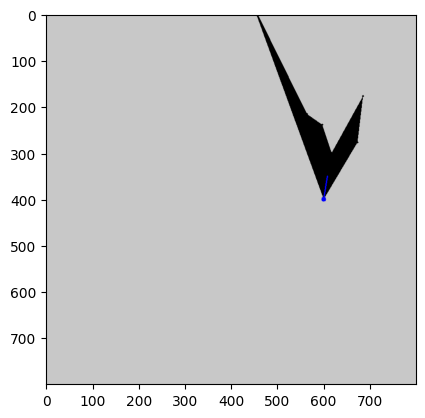

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
from skimage.draw import polygon


MAP_SCALE = 100        # px/m
MAP_SIZE = 800         # taille carte en px

def world_to_map(x, z):
    """Convertir coordonnées monde -> pixels carte"""
    px = int(MAP_SIZE // 2 + x * MAP_SCALE)
    pz = int(MAP_SIZE // 2 - z * MAP_SCALE)
    return px, pz

occupancy_grid = np.ones((MAP_SIZE, MAP_SIZE), dtype=np.int8) * -1

def draw_map():
    """Convertir la grille d’occupation en image affichable"""
    img = np.zeros((MAP_SIZE, MAP_SIZE, 3), dtype=np.uint8)
    img[occupancy_grid == -1] = (200, 200, 200)  # inconnu
    img[occupancy_grid == 0] = (255, 255, 255)  # libre
    img[occupancy_grid == 1] = (0, 0, 0)        # obstacle
    return img

px = 2
pz = 0
zy = -10

# Matrice de rotation autour de Y (dans le plan XZ)
world_matrix = np.array([
        [np.cos(math.radians(zy)), -np.sin(math.radians(zy)),px],
        [np.sin(math.radians(zy)),  np.cos(math.radians(zy)),pz],
        [0,0,1]
    ])

map_matrix =([
    [MAP_SCALE,0,MAP_SIZE // 2],
    [0,-MAP_SCALE,MAP_SIZE // 2],
    [0,0,1]
    ])

clip_distance_max = 5
nbP = 6
#lidar = np.ones(nbP) * 2.0
lidar = np.random.uniform(low=1, high=4, size=nbP)
px,pz = world_to_map(px,pz)

# les point de depth
fov = 60
W = nbP
fx = W / (2 * math.tan(math.radians(fov / 2)))
cx = W / 2

#ramener les point du lidar dans le repère du monde
r = np.arange(W)
r.astype(float)
valid = (lidar > 0) & (lidar < clip_distance_max) #remove from the depth image all values above a given value (meters).
valid = np.ravel(valid)
X = lidar * (r-cx) / fx
Z = np.ravel(lidar)[valid]
X = np.ravel(X)[valid]
X=np.stack((X,lidar,np.ones(nbP)))
X = world_matrix @ X
X = map_matrix @ X
for u in range(W):
  if u>0:
    x = np.array([pz, int(X[1][u]), int(X[1][u-1])])
    y = np.array([px, int(X[0][u]), int(X[0][u-1])])
    # Récupère les indices des pixels dans le triangle
    rr, cc = polygon(x, y, occupancy_grid.shape)
    # Remplir avec 1
    occupancy_grid[rr, cc] = 1

#position du robot
minimap = draw_map()
cv2.circle(minimap, (px,pz), 5, (0, 0, 255), -1)

# Dessiner l'orientation
l = world_matrix @ np.array([0, 0.5,1])
cv2.line(minimap, (px,pz), world_to_map(l[0], l[1]), (0, 0, 255), 2)

for u in range(W):
  cv2.circle(minimap, (int(X[0][u]), int(X[1][u])), 2, (0, 0, 0), -1)  # obstacle


# Display the array as a grayscale image
plt.imshow(minimap)
plt.show()

[0.   0.   0.   0.   0.   0.25 0.25 0.25 0.25 0.25 0.5  0.5  0.5  0.5
 0.5  0.75 0.75 0.75 0.75 0.75 1.   1.   1.   1.   1.  ]


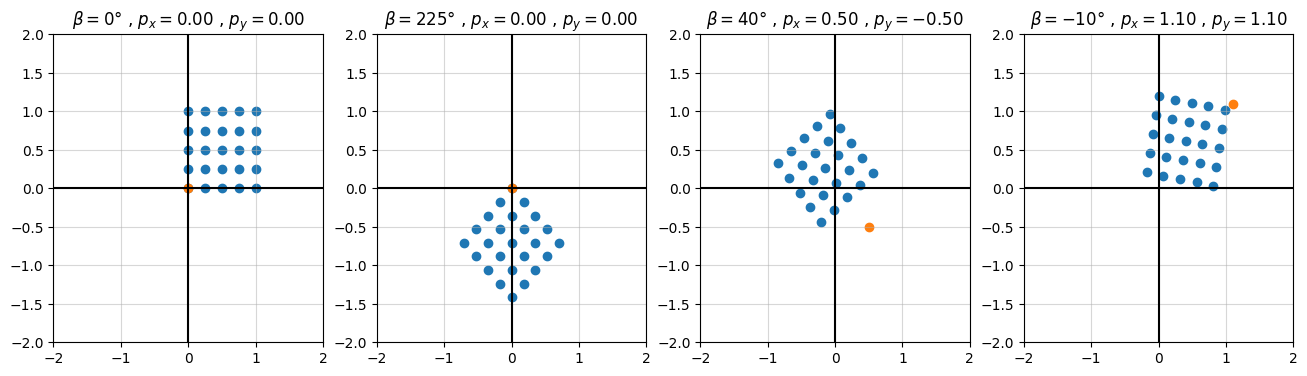

In [56]:
X, Y = np.mgrid[0:1:5j, 0:1:5j]
x, y = X.ravel(), Y.ravel()
plt.rcParams['figure.figsize'] = (16, 4)

def trans_rotate(x, y, px, py, beta):
    beta = np.deg2rad(beta)
    T = [[np.cos(beta), -np.sin(beta), px*(1 - np.cos(beta)) + py*np.sin(beta)],
         [np.sin(beta),  np.cos(beta), py*(1 - np.cos(beta)) - px*np.sin(beta)],
         [0           ,  0           , 1                                      ]]
    T = np.array(T)
    P = np.array([x, y, [1]*x.size])
    return np.dot(T, P)

fig, ax = plt.subplots(1, 4)

R_ = [0, 225, 40, -10]
P_ = [[0, 0], [0, 0], [0.5, -0.5], [1.1, 1.1]]

print(x)

for i in range(4):
    beta = R_[i]; px, py = P_[i]
    x_, y_, _ = trans_rotate(x, y, px, py, beta)
    ax[i].scatter(x_, y_)
    ax[i].scatter(px, py)
    ax[i].set_title(r'$\beta={0}°$ , $p_x={1:.2f}$ , $p_y={2:.2f}$'.format(beta, px, py))

    ax[i].set_xlim([-2, 2])
    ax[i].set_ylim([-2, 2])
    ax[i].grid(alpha=0.5)
    ax[i].axhline(y=0, color='k')
    ax[i].axvline(x=0, color='k')

plt.show()

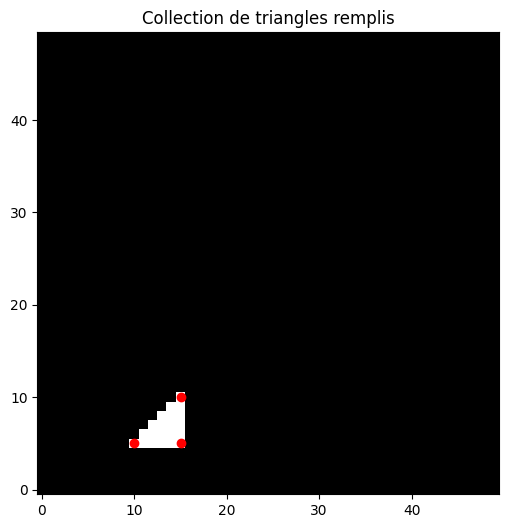

In [9]:
import numpy as np
from skimage.draw import polygon

MAP_SIZE = 50
occupancy_grid = np.ones((MAP_SIZE, MAP_SIZE), dtype=np.int8) * -1

# Coordonnées des sommets
x = np.array([5, 5, 10])   # Axe vertical (lignes)
y = np.array([10, 15, 15]) # Axe horizontal (colonnes)

# Récupère les indices des pixels dans le triangle
rr, cc = polygon(x, y, occupancy_grid.shape)

# Remplir avec 1
occupancy_grid[rr, cc] = 1


# Affichage
plt.figure(figsize=(6, 6))
plt.imshow(occupancy_grid, cmap="gray", origin="lower")
for (xs,ys) in zip(x,y):
    #xs, ys = zip(*tri)
    plt.scatter(ys, xs, color="red")  # sommets
plt.title("Collection de triangles remplis")
plt.show()